In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *

import learning_utils
import random


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

In [2]:
pid = 193
qid = 7638
q = Query.objects.get(pk=qid)
p = Project.objects.get(pk=pid)

other_docs = Doc.objects.filter(docproject__project=p, PY__gt=2012).exclude(query=q)

for d in other_docs:
    d.query.add(q)

q.r_count = q.doc_set.count()
q.save()
q.r_count

75070

In [3]:
q.doc_set.filter(PY=2012).count()

4

In [4]:
docs = Doc.objects.filter(query=q, content__iregex='\w').values_list('pk', flat=True)

print(docs.count())

seen = set(DocOwnership.objects.filter(
    query=q, 
    relevant__gt=0
).values_list('doc__pk', flat=True))


seen = seen & set(docs)

seen_docs = Doc.objects.filter(pk__in=seen)
seen_docs.count()

62494


2257

In [5]:
DocProject.objects.filter(project=p).values('relevant').annotate(
    n = Count('pk')
)

<QuerySet [{'relevant': 0, 'n': 113056}, {'relevant': 1, 'n': 403}, {'relevant': 3, 'n': 119}, {'relevant': 2, 'n': 1764}]>

In [6]:
unseen_docs = docs.exclude(pk__in=seen).distinct('id')

unseen_docs.count()

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(60237, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,46,Glaciers store water over a range of temporal ...,A review of methods for estimating the contrib...,climate change; glacier meltwater; hydrologica...,"[Geography, Physical; Geosciences, Multidiscip...",0,0
1,111,1 .Gradients in elevation are increasingly use...,Changes in host-parasitoid food web structure ...,climate change; elevation; experimental manipu...,[Ecology; Zoology],0,0
2,260,Phytosanitary risks are an increasing threat f...,An economic comparison of risk handling measur...,Phytosanitary risks; Cause-oriented measures; ...,[Forestry],0,0
3,274,Regenerative sustainability is emerging as an ...,Regenerative sustainability for the built envi...,Regenerative sustainability; Theory; Framework...,[Green & Sustainable Science & Technology; Eng...,0,0
4,297,Grass silage is typically fed to dairy cows in...,Effects of nitrogen fertilisation rate and mat...,nitrogen fertilisation; grass maturity; ryegra...,"[Agriculture, Dairy & Animal Science; Veterina...",0,0


In [7]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])

    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if not dos.exists():
        dos = DocOwnership.objects.filter(
            project=p,doc=d,relevant__gt=0,
        ).values_list('relevant',flat=True)            
    if len(set(dos))==1: # If there is only one value (all ratings agree)
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2 or dos[0] == 4:
            r['relevant'] = 0
        else:
            continue
        r_docs.append(r)
    
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant"]]
seen_df['seen'] = 1
print(seen_df.shape)
seen_df.head()

(2159, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,3095,"Many coasts are eroding. In the Comoros, as in...",Seawalls as a response to coastal erosion and ...,Grande Comore; Comoros; Seawalls; Coastal eros...,[Environmental Sciences; Environmental Studies],1,1
1,3309,"Since the 1970s, the Niger basin has been char...",Hydro-climatic changes in the Niger basin and ...,Regional climate change; Hydrology; Perception...,[Environmental Sciences; Environmental Studies],1,1
2,4590,1. Macrophysiology is the investigation of var...,Macrophysiology - progress and prospects,clines; environmental change; evolutionary eco...,[Ecology],0,1
3,7496,Liriomyza sativae and L. trifolii (Diptera: Ag...,Does Temperature-Mediated Reproductive Success...,None,[Multidisciplinary Sciences],0,1
4,8968,The heterogeneous topography of the Great Basi...,Life in an extreme environment: a historical p...,adaptation; body-size evolution; climate chang...,[Zoology],0,1


In [8]:
df = pd.concat([seen_df,unseen_df]).sample(frac=1).reset_index(drop=True)
y = df['relevant']
df.head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,879171,Dobrogea is a region of Romania with a high ec...,Management of drought and floods in the Dobrog...,None,None,0,0
1,1430110,Forest conditions prior to extensive land clea...,Landscape-scale modeling of reference period f...,dendroecology; ecological modeling; fire behav...,[Ecology],0,0
2,171517,Purpose - The purpose of this paper is to expl...,Resilience - an emerging paradigm of danger or...,Resilience; Disasters; Disaster risk reduction...,"[Environmental Studies; Public, Environmental ...",0,0
3,2389302,Evolutionary approaches are gaining popularity...,Conservation through the lens of (mal)adaptati...,adaptation; demographic rescue; evolutionary r...,[Evolutionary Biology],0,0
4,1282808,Severe droughts have caused widespread tree mo...,Triggers of tree mortality under drought,None,[Multidisciplinary Sciences],0,0


In [9]:
duplicateRowsDF = df[df.duplicated(['title'])]
print(duplicateRowsDF.shape)

duplicateRowsDF.head()



(448, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
2165,45099,"Aims Arid environments are resource limited, w...",Spatiotemporal variation in the endangered Thy...,None,None,0,0
3474,2408102,"Environments often vary across a life cycle, i...",Stage-specific genotype-by-environment interac...,None,None,0,0
4954,143454,This chapter sets the context of the book in g...,Introduction,None,None,0,0
5060,158922,Urban heat island (UHI) is micro-climatic phen...,Introduction,None,None,0,0
7855,175997,The term river herring collectively refers to ...,Projected ocean warming creates a conservation...,alewife; Alosa; bioclimatic envelope; blueback...,[Fisheries; Marine & Freshwater Biology; Ocean...,0,0


In [10]:
for i, row in duplicateRowsDF.iterrows():
    if len(row['title'].split()) < 3:
        print(row['title'])
        continue
    d = Doc.objects.get(pk=row['id'])
    ds = Doc.objects.filter(
        tslug=Doc.make_tslug(d.title),
        PY=d.PY
    )
    if ds.count() > 1:
        print(ds.values('title','id'))
        try:
            wd = ds.get(UT__UT__icontains="WOS:")
            sd = ds.exclude(UT__UT__icontains="WOS:")
        except:
            wd = ds.first()
            sd = ds.exclude(pk=wd.pk)
            #print(sd)
            #continue
        
        for d in sd:
            for do in d.docownership_set.filter(query__project=p):
                if DocOwnership.objects.filter(user=do.user,doc=do.doc).exists():
                    do.delete()
                else:
                    do.doc=wd
                    do.save()
            for q in d.query.filter(project=p):
                d.query.remove(q)
            try:
                DocProject.objects.get(doc=d,project=p).delete()
            except:
                pass
            
            dut = d.UT
            sid = dut.UT
            dut.UT = dut.UT+"dup"
            dut.save()
        wut = wd.UT
        wut.sid = sid
        wut.save()
            
        

Introduction
Introduction
Flowering time
Introduction
Soil Formation
<QuerySet [{'title': 'Landslides in West Coast metropolitan areas: The role of extreme weather events', 'id': 182284}, {'title': 'Landslides in West Coast metropolitan areas: The role of extreme weather events', 'id': 1876630}]>
Introduction
Introduction
<QuerySet [{'title': 'The importance of roads, nutrients, and climate for invasive plant establishment in riparian areas in the northwestern United States', 'id': 698489}, {'title': 'The importance of roads, nutrients, and climate for invasive plant establishment in riparian areas in the northwestern United States', 'id': 1516951}]>
Conclusion
Preface
Economics
<QuerySet [{'title': 'A review of numerical simulation methods for geomechanical problems induced by CO2 geological storage', 'id': 478732}, {'title': 'A review of numerical simulation methods for geomechanical problems induced by CO2 geological storage', 'id': 1816720}]>
<QuerySet [{'title': 'Maintenance of ea

In [11]:
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
#pred_index = pd.Index(random.sample(list(unseen_index),5000))

k = math.ceil(len(seen_index)*0.8)
train_index = pd.Index(random.sample(list(seen_index),k))

print(seen_index)
print(train_index)

#experiment_index = pd.Index(set(seen_index) | set(pred_index))

test_index = pd.Index([x for x in seen_index if x not in train_index])


Int64Index([   46,    68,    69,    75,   131,   162,   164,   177,   207,
              212,
            ...
            62173, 62199, 62248, 62254, 62258, 62261, 62309, 62312, 62327,
            62393],
           dtype='int64', length=2159)
Int64Index([29827, 18297, 17612, 23878,  6918, 45458, 29894, 35346, 51303,
            23139,
            ...
             5233, 23268, 12227, 29993, 47906, 36673, 24344, 32974, 58643,
            34717],
           dtype='int64', length=1728)


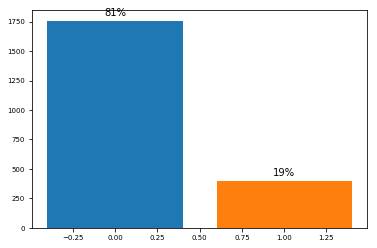

In [12]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

In [13]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=4, max_df=0.8, strip_accents='unicode', 
    max_features=10000,
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=learning_utils.tokenize
)

y = df['relevant']
ab_X = vec.fit_transform(df['content'])

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


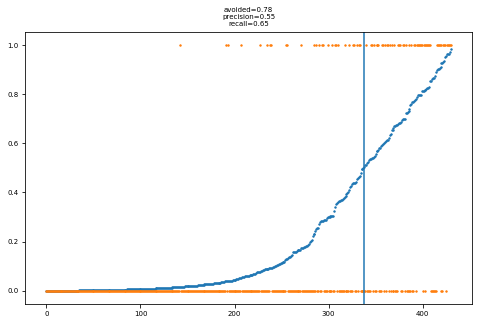

In [14]:
import importlib
importlib.reload(learning_utils)

clf = MultinomialNB(alpha=0.1)
clf.fit(ab_X[train_index],y[train_index])

fig, ax = plt.subplots(figsize=(8,5))
learning_utils.plot_model_accuracy(clf,ab_X[test_index],y[test_index],ax,0.5)

In [15]:
from sklearn.model_selection import KFold

model = {}
model['p'] = []
model['r'] = []
model['e'] = []
model['i'] = []

kf = KFold(n_splits=5)

for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    clf = MultinomialNB(alpha=0.1)
    clf.fit(ab_X[k_train],y[k_train])
    predictions = clf.predict(ab_X[k_test])
    model['e'].append(clf.score(ab_X[k_test],y[k_test]))
    # Precision
    model['p'].append(precision_score(predictions,y[k_test]))
    # Recall
    model['r'].append(recall_score(predictions,y[k_test]))
    #print(k_train)
    

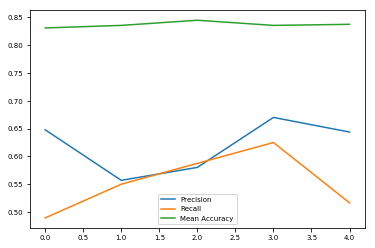

In [16]:
fig, ax = plt.subplots()
ax.plot(model['p'],label="Precision")
ax.plot(model['r'],label="Recall")
ax.plot(model['e'],label="Mean Accuracy")

plt.legend()

plt.show()

In [17]:
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    for model in models:
        clf = model['model']
        i+=1
        model['i'].append(i)
        #clf = SVC(kernel='rbf',probability=True)
        clf.fit(ab_X[k_train],y[k_train])
        predictions = clf.predict(ab_X[k_test])
        model['e'].append(clf.score(ab_X[k_test],y[k_test]))
        # Precision
        model['p'].append(precision_score(predictions,y[k_test]))
        # Recall
        model['r'].append(recall_score(predictions,y[k_test]))

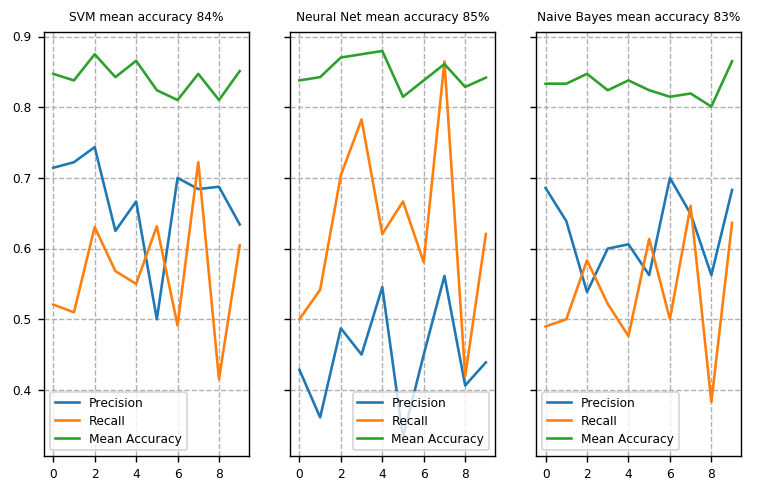

In [18]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
for i, model in enumerate(models):
    ax = axs[i]
    ax.plot(model['p'],label="Precision")
    ax.plot(model['r'],label="Recall")
    ax.plot(model['e'],label="Mean Accuracy")
    
    ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
    ax.grid()
    ax.legend()
    
plt.show()

In [19]:
clf =  MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

#clf = SVC(kernel='linear',class_weight='balanced',probability=True)


clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

In [20]:
df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

3862
62396


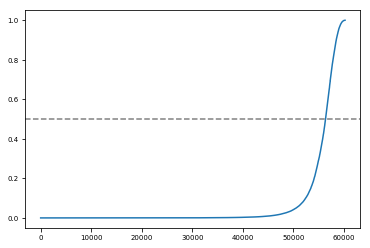

In [21]:
plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf.shape[0])

plt.show()

In [22]:
q = Query.objects.get(pk=qid)
q

<Query: published 2013+>

In [25]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

t1 = Tag(
    title="predicted relevant sample (comparison) {}".format(now),
    query=q
)
t1.save()

t2 = Tag(
    title="predicted relevant sample_2 {}".format(now),
    query=q
)
t2.save()

tag = t1

users = q.users.all()
uc = len(users)
max_docs = 1000
docs_added = 0
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < 100:
            d.tag.add(t1)
            docs_added+=1
        elif docs_added < 1100:
            d.tag.add(t2)
            docs_added+=1
        else:
            break        

    
t1.update_tag()
t2.update_tag()

In [47]:
i

1036

In [41]:
df.to_csv(f'doctables/predictions_{now}.csv',index=False)